# Recomendação de Produtos


### Importação de bibliotecas

In [23]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
%matplotlib inline
from scipy.stats import zscore
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import requests
from io import StringIO
#setting up for customized printing
from IPython.display import Markdown, display
from IPython.display import HTML

## O Dataset:

O Dataset consiste num dataset público de ratings de produtos da Amazon.

### Pré-Processamento de dados

#### 1- Filtragem do Dataset

In [24]:
electronics = pd.read_csv('ratings_Electronics.csv', names=['userId', 'productId', 'Rating','timestamp'], header=None)
electronics.drop('timestamp', axis=1, inplace=True)
electronics_groupby_product_Ratings = electronics.groupby('productId')['Rating']
electronics_groupby_product_Ratings = pd.DataFrame(electronics_groupby_product_Ratings.count())
product_list_min50_ratings = electronics_groupby_product_Ratings[electronics_groupby_product_Ratings['Rating'] >= 30].index
electronics =  electronics[electronics['productId'].isin(product_list_min50_ratings)]
electronics_groupby_user_Ratings = electronics.groupby('userId')['Rating']
electronics_groupby_user_Ratings = pd.DataFrame(electronics_groupby_user_Ratings.count())
user_list_min50_ratings = electronics_groupby_user_Ratings[electronics_groupby_user_Ratings['Rating'] >= 30].index
electronics =  electronics[electronics['userId'].isin(user_list_min50_ratings)]
electronics = electronics[['userId', 'productId', 'Rating']]

In [25]:
electronics.head()

,userId,productId,Rating
118,AT09WGFUM934H,0594481813,3.0
200,A3BMUBUC1N77U8,0972683275,4.0
389,A6J8D9V5S9MBE,0972683275,5.0
492,A3CLWR1UUZT6TG,0972683275,5.0
583,A11NR4AJK9TNQM,0972683275,4.0


#### 2 - Colocar os dados no formato pivot cliente-produto e converter num matriz numpy (eficiência)

In [9]:
table = pd.pivot_table(electronics, values='Rating', index=['userId'],columns=['productId'], aggfunc=np.mean)
table=table.replace(np.nan, 0)
table.head()

productId,0594481813,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,...,B00KHR4ZL6,B00KI2BD1U,B00KIMX4EY,B00KINSDK8,B00KMRGF28,B00KPRWAX8,B00KWHMR6G,B00KYMCJF8,B00L26YDA4,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A107CTGSINY3GJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
matrix=np.matrix(table)
matrix=np.where(matrix>0, 1, 0)
matrix.shape

(2686, 26276)

#### 3- Divisão entre treino e teste

##### Vai ser realizada de forma a que cada cliente tenha 10 ratings de produtos no conjunto de teste, sendo os restantes para treino

In [27]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    # Para cada cliente
    for user in range(ratings.shape[0]):
        #Retirar os índices dos 10 ratings de teste aleatoriamente
        test_ratings = np.random.choice(np.nonzero(ratings[user, :])[0],size=10,replace=False).reshape(1,-1).tolist()[0]
        #Retirar os ratings de teste do conjunto de treino
        train[user, test_ratings] = 0.
        #Colocar os 10 ratings escolido no conjunto de teste
        test[user, test_ratings] = ratings[user, test_ratings]    
    return train, test
train, test = train_test_split(matrix)

### Métricas de avaliação do motor de recomendação

As métricas de avaliação de um algoritmo de ML na indústria devem reflectir os objectivos de negócio. Vamos assumir que no site em questão aparecem 10 produtos recomendados ao cliente. Deste modo, todas as métricas devem incidir sobre estes 10 produtos e a ordenação dos mesmos (um algoritmo deve ser valorizado se meter em primeiro lugar o produto mais relevante para o cliente), e a assertividade que estas recomendações têm em prever vandas futuras.

1- Mean Precision 

2- Mean Average Precision 

3- Cobertura de Gama - % de produtos no site sugeridos.

4- Personalization Index - índice de personalização (quantifica o grau de personalização das sugestões)


Para ilustrar, consideremos a precision que para 1 clientes, são feitas 3 sugestões ordenadas de 10 produtos. Nos vectores, aparecem as relevâncias reais dos produtos para o cliente:

In [28]:
S1= [1,1,1,1,1,0,0,0,0,0]

S2= [0,0,0,0,0,1,1,1,1,1]

#### 1- Mean Precision: Dentro dos 10 produtos sugeridos, quantos são relevantes para o cliente, em média:

Esta métrica não diferencia qualquer ordenação dos produtos:

In [29]:
def precision (S):
    S=np.array(S)
    return np.sum((S>0).astype(int))/S.shape[0]

print ('Precision S1: ' + str(precision(S1)))

print ('Precision S2: ' + str(precision(S2)))



Precision S1: 0.5
Precision S2: 0.5


#### 2- Mean Average Precision:  Corrige a métrica anterior pois considera a posição dos produtos relevantes ou não na lista recomendada

Apesar de ser um upgrade, continua a não considerar o grau de relevância pelo cliente, não diferenciando S1 e S2.

In [30]:
def average_precision (S):
    S=np.array(S)
    y_true= (S>0).astype(int)
    
    return np.mean(np.array([precision(S[:k+1]) for k in range(S.shape[0])]))

print ('Precision S1: ' + str(average_precision(S1)))

print ('Precision S2: ' + str(average_precision(S2)))



Precision S1: 0.8228174603174603
Precision S2: 0.17718253968253966


#### 3-Definir funções que fazem a média destas métricas para todos os clientes

In [15]:
def mean_precision(pred):

    return np.mean(np.array([precision(pred[user,:]) for user in range(pred.shape[0])]))

def mean_ap(pred):
 
    return np.mean(np.array([average_precision(pred[user,:]) for user in range(pred.shape[0])]))


# Algoritmos

## 1ª abordagem -  popularidade (baseline)

In [16]:
def predict_baseline(train, test):
    mean_sku = train.mean(axis=0)
    top10popular=np.flip(np.argsort(mean_sku)).reshape(-1,1)[:10].reshape(1,-1).tolist()[0]
    pred=test[:,top10popular]
    return pred

pred=predict_baseline(train, test)
print ('Mean Precision Baseline: ' + str(mean_precision(pred)))
print ('Mean AP Baseline: ' + str(mean_ap(pred)))

Mean Precision Baseline: 0.016306775874906927
Mean AP Baseline: 0.01827292309328795


## 2ª abordagem - Colaborative Filtering


O collaborative filtering baseia-se apenas nas preferências históricas dos utilizadores num conjunto de artigos. O pressuposto é que os utilizadores que concordaram no passado tendem também a concordar no futuro.  As preferências são expressas por métricas dos utilizadores, tais como page views, cliques, compras, ...



### Pontos Positivos:

. Colaborative Filtering não requer características sobre os artigos ou clientes para ser aplicado. Baseia-se apenas nos dados de vendas, page_views, ratings, etc. É adequado para sites que vendem uma gama variada de artigos.

.  As recommendações não se especializam demasiado no perfil de um utilizador e contém artigos que são completamente diferentes do que já compraram antes. Se o site não pretende sugerir apenas pares de ténis semelhantes aos que o cliente comprou, então deve-se utilizar collaborative filtering (pelo menos parcialmente), no motor de recomendação. Desta forma não serão sugeridos necessariamente apenas artigos idênticos mas também outros artigos diferentes que utilizadores idênticos costumam comprar ou ver.


### Pontos Negativos:

. Colaborative Filtering pode levar a alguns problemas como o cold start para novos produtos que não estão no site. Até que alguém os classifique, não são recomendados.

. A escassez de dados pode afectar a qualidade dos recomendadores baseados no utilizador e também acrescentar ao problema do arranque a frio acima mencionado.

. É pesado computacionalmente escalar este algoritmo

. Com uma implementação simples, as recomendações tendem a ser já populares, e os artigos menos populares podem ser ignorados. Portanto, no pré-processamento devem ser filtrados produtos muito populares, até porque estes os clientes já procuram sem necessidade de recomendação.


## Alternativa: Content - Based Approach

Pega em features dos produtos como reviews, características, etc e computa distâncias entre os mesmos. De seguida, sugere produtos idênticos (distância pequena) aos que o cliente viu, baseados nestas distâncias.


## Memory Based Collaborative Filtering

Memory Based Colaborative Filtering é uma família de algoritmos de recommendação de produtos que consiste em 2 passos:

1- Encontrar clientes semelhantes ao cliente em causa com base nas compras, page views, ratings, etc. Esta semelhança deverá ser calculada com métricas de distância entre clientes (distância do cosseno, correlação de pearson, ...)

2- Prever a probabilidade de compra de um produto por um cliente com base nos clientes semelhantes encontrados em 1). 

Existem múltiplas formas quer de encontrar utilizadores semelhantes e múltiplas formas de calcular a classificação com base na classificação de utilizadores semelhantes. 


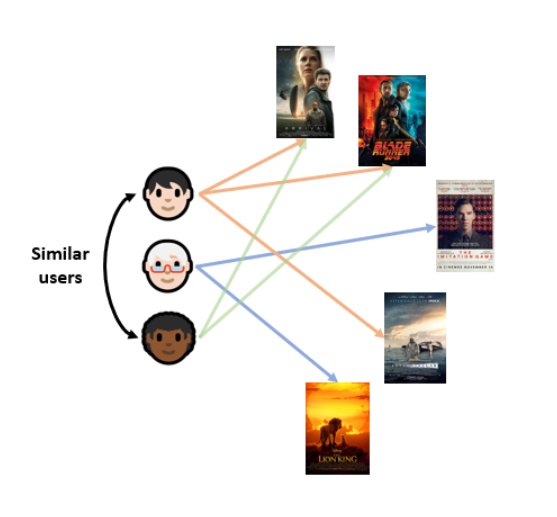

In [17]:
def fast_similarity(ratings, epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    
    sim = ratings.dot(ratings.T) + epsilon
    
    norms = np.array([np.sqrt(np.diagonal(sim))])
    
    sim_matrix=(sim / norms / norms.T)
    np.fill_diagonal(sim_matrix, 0)   
    
    return sim_matrix

In [18]:
user_similarity = fast_similarity(train)

In [19]:
user_similarity[:4,:4]

array([[0.00000000e+00, 1.06770356e-02, 1.58990750e-11, 1.58990750e-11],
       [1.06770356e-02, 0.00000000e+00, 1.45989291e-02, 1.45989291e-11],
       [1.58990750e-11, 1.45989291e-02, 0.00000000e+00, 2.17391304e-11],
       [1.58990750e-11, 1.45989291e-11, 2.17391304e-11, 0.00000000e+00]])

In [20]:
def predict_fast_simple(train,test, similarity):

    aux_pred= similarity.dot(train) / np.abs(similarity).sum(axis=1).reshape(-1,1)

           
    pred=np.zeros((aux_pred.shape[0],10))
    for user in range(aux_pred.shape[0]):
        pred_user=np.flip(np.argsort(aux_pred[user,:])).reshape(-1,1)[:10].reshape(1,-1).tolist()[0]
        pred[user, :] = test[user,pred_user]  
    return pred

In [21]:

user_prediction = predict_fast_simple(train,test, user_similarity)

print ('Mean Precision User CF: ' + str(mean_precision(user_prediction)))
print ('Mean AP User CF: ' + str(mean_ap(user_prediction)))

Mean Precision User CF: 0.018615040953090096
Mean AP User CF: 0.014692822276589959


### Refinement: considerar apenas os top k clientes + parecidos

In [31]:

def predict_topk(ratings, similarity, kind='user', k=40):
    aux_pred = np.zeros(ratings.shape)
    for i in range(ratings.shape[0]):

        top_k_users = np.flip(np.array(np.argsort(similarity[:,i],axis=None)).tolist())[:k]
        for j in range(ratings.shape[1]):
            aux_pred[i, j] = similarity[i, :].reshape(-1,1)[ top_k_users].T.dot(ratings[:, j][top_k_users]) 
            aux_pred[i, j] /= np.sum(np.abs(similarity[i, :].reshape(-1,1)[top_k_users]))
           
    
    pred=np.zeros((aux_pred.shape[0],10))
    for user in range(aux_pred.shape[0]):
        pred_user=np.flip(np.argsort(aux_pred[user,:])).reshape(-1,1)[:10].reshape(1,-1).tolist()[0]
        pred[user, :] = test[user,pred_user]  
    return pred

k_array = [100, 200,300,400]
for k in k_array:
    user_prediction_topk = predict_topk(test, user_similarity, k=k)
    print (f'Mean Precision User {k} nearest CF: ' + str(mean_precision(user_prediction_topk)))
    print (f'Mean AP {k} nearest CF: ' + str(mean_ap(user_prediction_topk)))

Mean Precision User 100 nearest CF: 0.0973938942665674
Mean AP 100 nearest CF: 0.13835197792197046


KeyboardInterrupt: 

## Model Based Collaborative Filtering

O método anterior continua a ter duas limitações:

. Uma é que só considera dois clientes semelhantes se tiverem comprado os mesmos produtos, mesmo que tenham comprado, produtos idênticos.

. Outra delas é a esparsidade e a escalabilidade.

Sugerimos então um método mais avançado que decompõe a matriz esparsa original em matrizes densas (de baixa dimensão). Estas matrizes formam uma nova representação (de menor dimensão) dos dados originais que mantém a informação mas é mais fácil de processar para os algoritmos.

### Singular Value Decomposition

Quando se trata de redução da dimensionalidade, a Decomposição de Valor Singular (SVD) é um método popular em álgebra linear para a factorização matricial no Machine Learning. Reduz a matriz no formato user-compra no produto de 3 matrizes:

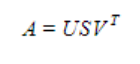

A é a nossa matriz user-compra de treino/teste de dimensão mxn, U is a m x r é uma matriz que contém a relação entre cada user e latent factor, S é uma matriz rxr diagonal, que descreve a força de cada latent factor e V é uma matriz que descreve a relação entre cada produto e latent factor.

In [ ]:
U, S, V = np.linalg.svd(train)

k = 50

R_Data= 